In [11]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter
from scipy.optimize import curve_fit
#import the functions from functions.py
import functions

import importlib

100%|██████████| 1000/1000 [00:11<00:00, 89.29it/s]


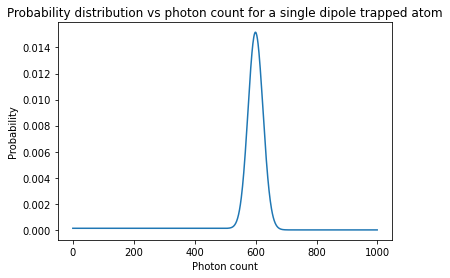

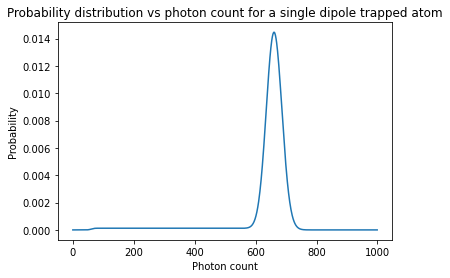

In [12]:
#define the variables that determine how many photons are released
recordTime = 60*10**-3  #s
rateSingleAtom = 10*10**3  #Hz
rateBackground = 1*10**3  #Hz
lifetimeOfTrap =  800*10**-3  #s
#up to this many photons
countEnd = 1000
xx = np.arange(countEnd)
#the background is just a poisson distribution
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
#get the distribution, the integrals take longer then the rest of the code
probDistSingle = functions.singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)
plt.plot(xx,probDistSingle)
plt.title("Probability distribution vs photon count for a single dipole trapped atom")
plt.xlabel("Photon count")
plt.ylabel("Probability")
plt.show()
#now convolve with background rate
probDistSingle = functions.convolve(probDistBack,probDistSingle)
plt.plot(xx,probDistSingle)
plt.title("Probability distribution vs photon count for a single dipole trapped atom")
plt.xlabel("Photon count")
plt.ylabel("Probability")
plt.show()

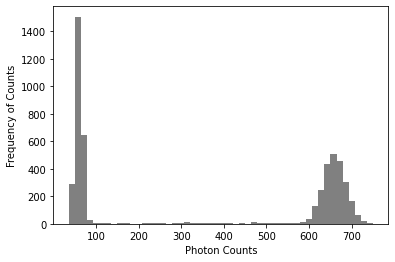

Background mean(rate*time): 60.00


In [13]:
hist = functions.runExperiment(probDistBack,probDistSingle,xx)
functions.graphHistogram(hist,xx,p0=[1000, 50, 1, 400, 600, 5],fit = False)
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground))

The integration takes a long time, this is my attempt at simulating atom loss during a measurement many times. Instead of taking an integral for each photon count, take the probability of the atom leaving the trap at time t for t from 0 to recorded time. At each of the steps change the probability that the atom will leave, then count up the amount of photons according to the status of the atom at that step(rate/totalTimeSteps). I tried taking a new sample from each dist at each step but that only created two very distinct gaussian dist far apart. I think that is interesting and it might have something to do with normal distrbutions and sample numbers. 



* The problem I am having is the fact that the simulation is just a poission distribution, I need that exponential tail like that of the analytical function.

* The standard deviation gets smaller with more experiments, I think that shows that the way I am having that atoms leave the trap is not right.

* There needs to be photon count values that are not clustered around the mean, there should be atoms leaving the trap and only producing the background rate. Instead, they are just averaging out to the same values, the background rate just moves the median.



In [14]:
def simulateAtomLoss(recordTime,trapLifetime,xx,probDistSingle,probDistBack,totalTimeSteps = 500,experiments = 500,debug = False):
    """ 
    simulates an atom being lossed during readout with given trap paramaters 
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        trapLifetime: the lifetime of the trap(seconds)
        xx: an array of integers that are the possible photon counts to measure
        probDistBack: the background probability distribution
        probDistSingle: the single atom probability distribution
    Returns:
        an array of probability distribution for a single atom 
    """
    
    #the total probability time, longer than record time so that we know if the atom stays in the trap
    timeIntegrate = np.linspace(0,recordTime*10,totalTimeSteps)
    #now we get the prob that the atom leaves the trap at time t
    time_dist = np.array([np.exp(-t/trapLifetime)/trapLifetime for t in timeIntegrate])
    #now we get random choices of when this thing happens
    timeArray = choices(timeIntegrate,time_dist,k = experiments)

    if debug:

        #plot the exponential decay(the probability it remains in trap)
        plt.plot(timeIntegrate,time_dist,'.')
        plt.show()
        #plot the random variables we got, a dist of when the atoms will leave
        plt.hist(timeArray,100)
        plt.show() 
        
    #just some couting for a percentage of how many atoms leave the trap 
    countLeft = 0

    #do the simulation

    #get if the atom left or not,get the time the left at as well 
    atomLeft_array = [(False,timeArray[e]) if recordTime <= timeArray[e] else (True,timeArray[e]) for e in range(experiments)]
    probDist = []
    for left,time in tqdm(atomLeft_array):
        if not left:
            #the atom never left
            probDist.append(choices(xx,probDistSingle)[0]+choices(xx,probDistBack)[0])
            
        else:
            #the atom left,only add a fraction of the record time 
            #from single atom 
            timeRatio = time/recordTime
            math = choices(xx,probDistSingle)[0]*timeRatio+choices(xx,probDistBack)[0]
            probDist.append(math)
            countLeft += 1
    print ("\nThe percentage of atoms that left the trap during readout %.2f%%" %(countLeft/experiments*100))
    return probDist

In [15]:
importlib.reload(functions)
N = 5000
single = poisson.pmf(xx,(rateSingleAtom)*recordTime)
probDistSimulated = simulateAtomLoss(recordTime,lifetimeOfTrap,xx,single,probDistBack,experiments=N)


100%|██████████| 5000/5000 [00:01<00:00, 3013.58it/s]
The percentage of atoms that left the trap during readout 14.32%



* The first plot above shows the decay from the equation
* The second shows the random sampling from the decay 

In [16]:
def getProbabilities(binBorders,binHeights,photonCount):
    
    #make integers(photons are integers)
    binBorders = np.round(binBorders).astype(int)
    probs = np.zeros_like(np.arange(photonCount),dtype=float)

    for i,h in enumerate(binHeights):
        probs[binBorders[i]:binBorders[i+1]] = h
    return probs        

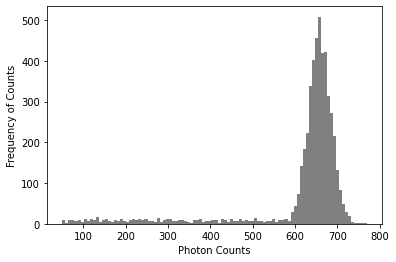

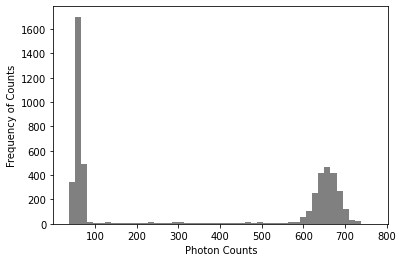

In [17]:
importlib.reload(functions)
binBorder,binHeight = functions.graphHistogram(probDistSimulated,xx,p0 = [50,600,10,.1,1,-10],fit = False,
                binNumber=100)
prob = getProbabilities(binBorder,binHeight,countEnd)                

h = functions.runExperiment(probDistBack,prob,xx)
_,_ = functions.graphHistogram(h,xx,fit = False)


* replace the choices function with the random package from numpy
* try to quantify the difference from the analytical solution
* maybe just supperimpose and any thing that doesnt overlap is the errro
* could use that error function to fit something like bin number to optimize
